In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Clone SAM 3 to Google Drive (only needs to be done once)
import os

SAM3_PATH = "/content/drive/MyDrive/sam3"

if not os.path.exists(SAM3_PATH):
    print("Cloning SAM 3 to Google Drive (one-time setup)...")
    !git clone https://github.com/facebookresearch/sam3.git "{SAM3_PATH}"
    print("✅ SAM 3 cloned to Drive!")
else:
    print(f"✓ SAM 3 already exists at: {SAM3_PATH}")

# Install SAM 3 from Drive location
%cd "{SAM3_PATH}"
!pip install -e .
%cd /content

# Install other dependencies, ensuring triton and pillow-heif are installed
!pip install -q pillow-heif triton decord

print("✅ Installation complete!")

✓ SAM 3 already exists at: /content/drive/MyDrive/sam3
/content/drive/MyDrive/sam3
Obtaining file:///content/drive/MyDrive/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sam3 (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-0.editable-py3-none-any.whl size=15374 sha256=fb7536f82169af732a2784b64e5c71c19c2e70c8610b20df187dda48ebc6bace
  Stored in directory: /tmp/pip-ephem-wheel-cache-zialgsn1/wheels/a9/f6/56/8bceed5d64a938729b7cd9ea739ee815f543ed3684d47504b4
Successfully built sam3
  Attempting uninstall: sam3
    Found existing installation: sam3 0.1.0
    Uninstalling sam3-0.1.0:
      Successfully uninstalled sam3-0.1.0


/content
✅ Installation complete!


In [1]:
# Verify installation
import sys
import torch

# Add SAM 3 from Drive to path
SAM3_PATH = "/content/drive/MyDrive/sam3"
if SAM3_PATH not in sys.path:
    sys.path.insert(0, SAM3_PATH)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Test SAM 3 import from Drive
from sam3 import model_builder
print("✓ SAM 3 imported successfully from Drive!")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
✓ SAM 3 imported successfully from Drive!


In [2]:
# Login to Hugging Face (required for SAM 3)
from huggingface_hub import login

# Get your token from: https://huggingface.co/settings/tokens
# Also accept license at: https://huggingface.co/facebook/sam3
login()

In [3]:
# Configuration - UPDATE THIS PATH!
DRIVE_PATH = "/content/drive/MyDrive/TRAIN"  # <-- Change to your folder path
OUTPUT_DIR = "/content/drive/MyDrive/segmented_output"

# Component classes
COMPONENT_CLASSES = ["seal", "tin", "screw", "hole", "glass"]

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Check if path exists
if os.path.exists(DRIVE_PATH):
    print(f"✓ Found TRAIN folder at: {DRIVE_PATH}")
    print(f"  Contents: {os.listdir(DRIVE_PATH)}")
else:
    print(f"✗ TRAIN folder not found at: {DRIVE_PATH}")
    print("  Please update DRIVE_PATH variable above")

✓ Found TRAIN folder at: /content/drive/MyDrive/TRAIN
  Contents: ['negative', 'positive']


In [4]:
import torch
import numpy as np
import cv2
from PIL import Image
import pillow_heif
from google.colab.patches import cv2_imshow

# Register HEIC support
pillow_heif.register_heif_opener()

# Check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## Load SAM 3 Model

In [5]:
# Load SAM 3 model
from sam3 import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor
import importlib # Import importlib for reloading modules

# BPE path from Drive location
SAM3_PATH = "/content/drive/MyDrive/sam3"
bpe_path = f"{SAM3_PATH}/sam3/assets/bpe_simple_vocab_16e6.txt.gz"
print(f"BPE path: {bpe_path}")
print(f"Exists: {os.path.exists(bpe_path)}")

print("Loading SAM 3 model (this may take a few minutes)...")

# Reload the patched modules to ensure changes are picked up
try:
    if 'sam3.model.position_encoding' in sys.modules:
        importlib.reload(sys.modules['sam3.model.position_encoding'])
        print("✓ Reloaded sam3.model.position_encoding.")
    else:
        print("sam3.model.position_encoding not yet loaded, no need to reload.")
except Exception as e:
    print(f"Error reloading sam3.model.position_encoding: {e}")

try:
    if 'sam3.model_builder' in sys.modules:
        importlib.reload(sys.modules['sam3.model_builder'])
        print("✓ Reloaded sam3.model_builder.")
    else:
        print("sam3.model_builder not yet loaded, no need to reload.")
except Exception as e:
    print(f"Error reloading sam3.model_builder: {e}")

# Pass the 'device' variable to the model builder, and remove CUDA-specific optimizations
# as we are running on CPU.
model = build_sam3_image_model(bpe_path=bpe_path, device=device)
processor = Sam3Processor(model, confidence_threshold=0.3)
print("✓ SAM 3 loaded successfully!")

BPE path: /content/drive/MyDrive/sam3/sam3/assets/bpe_simple_vocab_16e6.txt.gz
Exists: True
Loading SAM 3 model (this may take a few minutes)...
✓ Reloaded sam3.model.position_encoding.
✓ Reloaded sam3.model_builder.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sam3.pt:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

✓ SAM 3 loaded successfully!


In [6]:
# Patching sam3/model/position_encoding.py to use CPU
import os

position_encoding_path = os.path.join(SAM3_PATH, 'sam3/model/position_encoding.py')

if os.path.exists(position_encoding_path):
    with open(position_encoding_path, 'r') as f:
        content = f.read()

    original_line = '                tensors = torch.zeros((1, 1) + size, device="cuda")'
    patched_line = '                tensors = torch.zeros((1, 1) + size, device="cpu")'

    if original_line in content:
        content = content.replace(original_line, patched_line)
        with open(position_encoding_path, 'w') as f:
            f.write(content)
        print("✅ Patched sam3/model/position_encoding.py for CPU execution.")
    else:
        print("✗ Patch not needed or already applied to position_encoding.py.")
else:
    print(f"✗ Error: {position_encoding_path} not found.")

# Re-run the model loading cell after patching


✗ Patch not needed or already applied to position_encoding.py.


## Option A: Use SAM 3 with Text Prompts (No YOLO training needed)

This uses SAM 3's text understanding to find components directly.
Components: **seal, tin, screw, hole, glass**

In [7]:
def load_image(image_path):
    """Load image (supports HEIC, JPG, PNG)"""
    try:
        img = Image.open(image_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None


def segment_with_text_prompt(pil_image, text_prompt):
    """Segment using SAM 3 text prompt (official API)"""
    # Set the image
    inference_state = processor.set_image(pil_image)

    # Prompt with text
    inference_state = processor.set_text_prompt(
        state=inference_state,
        prompt=text_prompt
    )

    # Get results from inference_state
    masks = inference_state.get("masks", [])
    boxes = inference_state.get("boxes", [])
    scores = inference_state.get("scores", [])

    return masks, boxes, scores


def process_image_with_text(image_path, output_path):
    """Process single image using text prompts for each component"""
    print(f"\nProcessing: {os.path.basename(image_path)}")

    # Load image
    pil_image = load_image(image_path)
    if pil_image is None:
        return None

    # Resize if too large (for memory)
    max_dim = 1024
    w, h = pil_image.size
    if max(h, w) > max_dim:
        scale = max_dim / max(h, w)
        pil_image = pil_image.resize((int(w*scale), int(h*scale)), Image.LANCZOS)
        print(f"  Resized to {pil_image.size}")

    # Convert for visualization
    image_np = np.array(pil_image)
    annotated = image_np.copy()

    all_results = {}

    # Segment each component type
    for component in COMPONENT_CLASSES:
        print(f"  Detecting: {component}...", end=" ")
        try:
            masks, boxes, scores = segment_with_text_prompt(pil_image, component)

            if masks is not None and len(masks) > 0:
                print(f"Found {len(masks)}")
                all_results[component] = {
                    'masks': masks,
                    'boxes': boxes,
                    'scores': scores
                }

                # Draw masks with random colors
                for i, mask in enumerate(masks):
                    if isinstance(mask, torch.Tensor):
                        mask_np = mask.cpu().numpy()
                    else:
                        mask_np = np.array(mask)

                    mask_bool = mask_np.astype(bool)
                    if mask_bool.ndim > 2:
                        mask_bool = mask_bool.squeeze()

                    color = np.random.randint(50, 255, 3).tolist()
                    annotated[mask_bool] = (annotated[mask_bool] * 0.5 + np.array(color) * 0.5).astype(np.uint8)

                    # Draw contour and label
                    contours, _ = cv2.findContours(
                        mask_bool.astype(np.uint8),
                        cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE
                    )
                    cv2.drawContours(annotated, contours, -1, color, 2)

                    # Add label at centroid
                    if len(contours) > 0:
                        M = cv2.moments(contours[0])
                        if M["m00"] > 0:
                            cx = int(M["m10"] / M["m00"])
                            cy = int(M["m01"] / M["m00"])
                            cv2.putText(annotated, component, (cx-20, cy),
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
            else:
                print("None found")

        except Exception as e:
            print(f"Error: {e}")

    # Save result
    annotated_bgr = cv2.cvtColor(annotated.astype(np.uint8), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, annotated_bgr)
    print(f"  Saved: {output_path}")

    return all_results, annotated

Testing with: /content/drive/MyDrive/TRAIN/negative/IMG_5401 2.HEIC

Processing: IMG_5401 2.HEIC
  Resized to (1024, 768)
  Detecting: seal... None found
  Detecting: tin... None found
  Detecting: screw... Found 28
  Detecting: hole... Found 28
  Detecting: glass... Found 12
  Saved: /content/drive/MyDrive/segmented_output/test_result.jpg


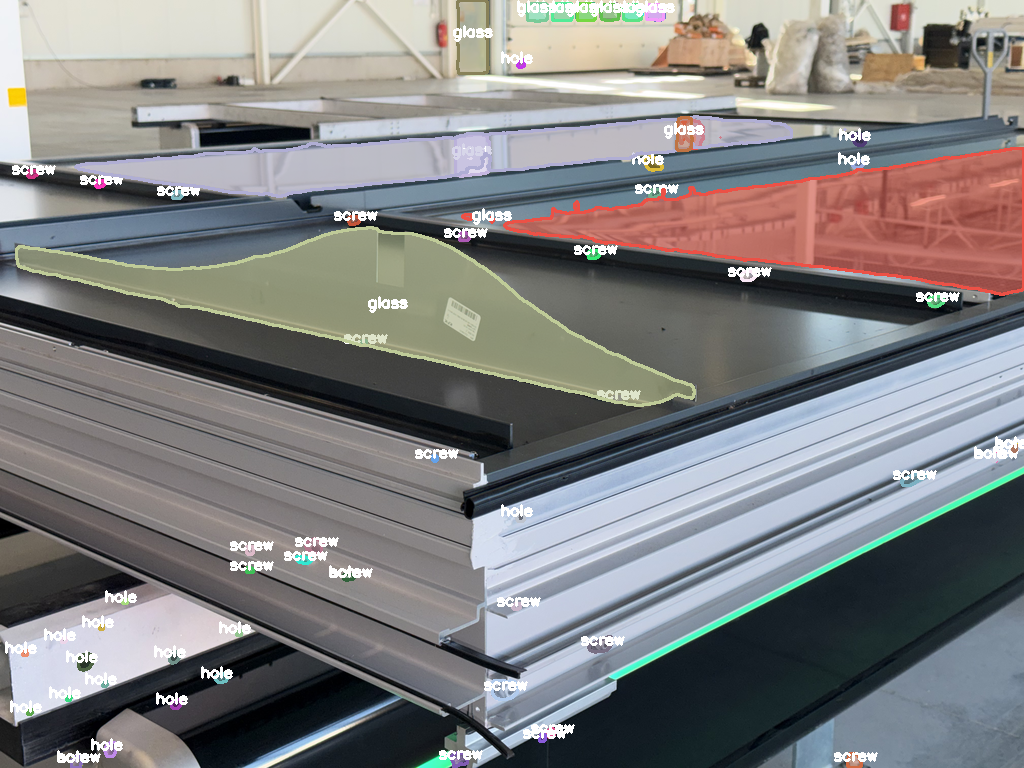

In [8]:
# Test on a single image first
import glob

# Find first image
test_images = glob.glob(f"{DRIVE_PATH}/**/*.*", recursive=True)
test_images = [f for f in test_images if f.lower().endswith(('.jpg', '.jpeg', '.png', '.heic', '.heif'))]

if test_images:
    test_path = test_images[0]
    print(f"Testing with: {test_path}")

    result, annotated = process_image_with_text(
        test_path,
        f"{OUTPUT_DIR}/test_result.jpg"
    )

    # Display result
    from IPython.display import display
    display(Image.fromarray(annotated.astype(np.uint8)))
else:
    print("No images found. Check DRIVE_PATH.")

## Process All Images

In [10]:
def process_folder(folder_path, output_folder):
    """Process all images in a folder"""
    os.makedirs(output_folder, exist_ok=True)

    extensions = ('.jpg', '.jpeg', '.png', '.heic', '.heif')
    images = [f for f in os.listdir(folder_path)
              if f.lower().endswith(extensions) and not f.startswith('.')]

    print(f"\n{'='*50}")
    print(f"Processing {len(images)} images from {folder_path}")
    print(f"{'='*50}")

    for i, img_file in enumerate(images):
        print(f"\n[{i+1}/{len(images)}]", end=" ")

        input_path = os.path.join(folder_path, img_file)
        base_name = os.path.splitext(img_file)[0].replace(" ", "_")
        output_path = os.path.join(output_folder, f"{base_name}_segmented.jpg")

        try:
            process_image_with_text(input_path, output_path)
        except Exception as e:
            print(f"  Error: {e}")

    print(f"\n{'='*50}")
    print(f"Done! Results saved to: {output_folder}")

In [ ]:
# Process positive folder
positive_path = os.path.join(DRIVE_PATH, "positive")
if os.path.exists(positive_path):
    process_folder(positive_path, os.path.join(OUTPUT_DIR, "positive"))
else:
    print(f"Positive folder not found: {positive_path}")


Processing 12 images from /content/drive/MyDrive/TRAIN/positive

[1/12] 
Processing: IMG_5675.HEIC
  Resized to (1024, 768)
  Detecting: seal... None found
  Detecting: tin... None found
  Detecting: screw... Found 11
  Detecting: hole... Found 16
  Detecting: glass... Found 4
  Saved: /content/drive/MyDrive/segmented_output/positive/IMG_5675_segmented.jpg

[2/12] 
Processing: IMG_5658.HEIC
  Resized to (1024, 768)
  Detecting: seal... None found
  Detecting: tin... None found
  Detecting: screw... Found 23
  Detecting: hole... Found 21
  Detecting: glass... Found 53
  Saved: /content/drive/MyDrive/segmented_output/positive/IMG_5658_segmented.jpg

[3/12] 
Processing: IMG_5478 3.HEIC
  Resized to (1024, 768)
  Detecting: seal... None found
  Detecting: tin... 

In [ ]:
# Process negative folder
negative_path = os.path.join(DRIVE_PATH, "negative")
if os.path.exists(negative_path):
    process_folder(negative_path, os.path.join(OUTPUT_DIR, "negative"))
else:
    print(f"Negative folder not found: {negative_path}")

## Done! 🎉

Your segmented images are saved in Google Drive at:
`/content/drive/MyDrive/segmented_output/`